In [1]:
import os
import sys
import pandas as pd
import math

os.chdir('./scripts')

import load_config
import matplotlib.pyplot as plt
import sweetviz as sv
import numpy as np
import seaborn as sns
import datetime

In [2]:
os.getcwd()

'/home/rauljcuesta/master/repo_tfm/scripts'

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
config = load_config.load_config_const()
plt.style.use('seaborn')

In [5]:
config['files_dgt']

['export_anual_trf_2015.csv.tar.gz',
 'export_anual_trf_2016.csv.tar.gz',
 'export_anual_trf_2017.csv.tar.gz',
 'export_anual_trf_2018.csv.tar.gz',
 'export_anual_trf_2019.csv.tar.gz',
 'export_anual_trf_2020.csv.tar.gz',
 'export_anual_trf_2021.csv.tar.gz']

# Estudio del Dataset de transacciones de turismos de la DGT

El presente notebook tiene como objetivo hace un estudio de las características relevantes del dataset de transferencias de turismos.

## 1. Carga de datos

Debido al pandas, al convertir los datos en un dataframe, el campo de código postal es convertido en tipo númerico float o integer. Es necesario reconstruir los códigos.

In [6]:
def cod_postal_zero_int_repair(cod_postal):
    if (not math.isnan( cod_postal )):
        cod_postal = int(cod_postal)
        if ( len(str(cod_postal)) == 5 ):
            return str(cod_postal)
        elif ( len(str(int(cod_postal))) == 4 ):
            return '0'+str(int(cod_postal))
        else:
            return int(cod_postal)
    else:
        return cod_postal

La siguiente función se usa para obtener el código de provincia del código postal

In [7]:
def return_id_province_by_zip(cod_postal):
    if (cod_postal):
        cod_postal = str(cod_postal)
        return cod_postal[0:2]
    else:
        return cod_postal

is_weekend se usa para obtener si el día del traspaso es fin de semana, ya que, como se verá más adelante, estos días los traspasos de vehículos son mínimos. Interesante conocer esto para implementar la serie temporal y obtener una predición más fiable.

In [8]:
def is_weekend(day_week):
    if (day_week == 'Saturday' or day_week == 'Sunday'):
        return True
    else:
        return False

Crea una correspondencia de código de provincia y su nombre

In [9]:
def return_province(id_province):
    list_ids_province = {
        '01': 'Álava',
        '08': 'Barcelona',
        '15': 'La Coruña',
        '23': 'Jaén',
        '30': 'Murcia',
        '38': 'Santa Cruz de Tenerife',
        '45': 'Toledo',
        '02': 'Albacete',
        '09': 'Burgos',
        '16': 'Cuenca',
        '24': 'León',
        '31': 'Navarra',
        '46': 'Valencia',
        '03': 'Alicante',
        '10': 'Cáceres',
        '17': 'Gerona',
        '25': 'Lérida',
        '32': 'Orense',
        '39': 'Cantabria',
        '47': 'Valladolid',
        '04': 'Almería',
        '11': 'Cádiz',
        '18': 'Granada',
        '26': 'La Rioja',
        '33': 'Asturias',
        '40': 'Segovia',
        '48': 'Vizcaya',
        '05': 'Ávila',
        '12': 'Castellón',
        '19': 'Guadalajara',
        '34': 'Palencia',
        '41': 'Sevilla',
        '49': 'Zamora',
        '06': 'Badajoz',
        '13': 'Ciudad Real',
        '20': 'Guipúzcoa',
        '27': 'Lugo',
        '35': 'Las Palmas',
        '42': 'Soria',
        '50': 'Zaragoza',
        '07': 'Islas Baleares',
        '21': 'Huelva',
        '28': 'Madrid',
        '36': 'Pontevedra',
        '43': 'Tarragona',
        '51': 'Ceuta',
        '14': 'Córdoba',
        '22': 'Huesca',
        '29': 'Málaga',
        '37': 'Salamanca',
        '44': 'Teruel',
        '52': 'Melilla'
    }
    
    return list_ids_province.get(id_province)

Debido a que algunas marcas se dan de alta con distinto nombre, es requerido una forma de unificar las marcas y así ser más preciso a la hora de contabilizar los traspasos por marca

In [10]:
def return_make(make):
    list_makes = {
        'ABARTH': 'ABARTH',
        'ALFA': 'ALFA ROMEO',
        'ALFA ROMEO': 'ALFA ROMEO',
        'ASTON MARTIN': 'ASTON MARTIN',
        'AUDI': 'AUDI',
        'BENTLEY': 'BENTLEY',
        'BMW': 'BMW',
        'BMW I': 'BMW',
        'CADILLAC': 'CADILLAC',
        'CHEVROLET': 'CHEVROLET',
        'CHRYSLER': 'CHRYSLER',
        'CITROEN': 'CITROEN',
        'CUPRA': 'CUPRA',
        'DACIA': 'DACIA',
        'DAEWOO': 'DAEWOO',
        'DAIHATSU': 'DAIHATSU',
        'DAIMLER': 'DAIMLER',
        'DAIMLER AG': 'DAIMLER',
        'DAIMLER CHRYSLER': 'CHRYSLER',
        'DODGE': 'DODGE',
        'DS': 'DS',
        'FERRARI': 'FERRARI',
        'FIAT': 'FIAT',
        'FORD': 'FORD',
        'FORD CNG TECHNIK': 'FORD',
        'FORD-CNG-TECHNIK': 'FORD',
        'GMC': 'GMC',
        'HONDA': 'HONDA',
        'HUMMER': 'HUMMER',
        'HYUNDAI': 'HYUNDAI',
        'INFINITI': 'INFINITI',
        'ISUZU': 'ISUZU',
        'IVECO': 'IVECO',
        'JAGUAR': 'JAGUAR',
        'JAGUAR LAND ROVER LIMIT': 'LAND-ROVER',
        'JEEP': 'JEEP',
        'KIA': 'KIA',
        'LADA': 'LADA',
        'LAMBORGHINI': 'LAMBORGHINI',
        'LANCIA': 'LANCIA',
        'LAND ROVER': 'LAND-ROVER',
        'LEXUS': 'LEXUS',
        'LOTUS': 'LOTUS',
        'M.G': 'MG',
        'MAHINDRA': 'MAHINDRA',
        'MASERATI': 'MASERATI',
        'MAZDA': 'MAZDA',
        'MCC SMART': 'SMART',
        'MCLAREN': 'MCLAREN',
        'MERCEDES': 'MERCEDES-BENZ',
        'MERCEDES-AMG': 'MERCEDES-BENZ',
        'MERCEDES-BENZ': 'MERCEDES-BENZ',
        'MG': 'MG',
        'MICRO COMPACT CAR': 'SMART',
        'MINI': 'MINI',
        'MITSUBISHI': 'MITSUBISHI',
        'NISSAN': 'NISSAN',
        'OPEL': 'OPEL',
        'PEUGEOT': 'PEUGEOT',
        'PORSCHE': 'PORSCHE',
        'QUATTRO': 'AUDI',
        'RANGE ROVER': 'ROVER',
        'RENAULT': 'RENAULT',
        'ROVER': 'ROVER',
        'SAAB': 'SAAB',
        'SANTANA': 'SANTANA',
        'SEAT': 'SEAT',
        'SEAT FIAT': 'SEAT',
        'SKODA': 'SKODA',
        'SMART': 'SMART',
        'SSANGYONG': 'SSANGYONG',
        'SUBARU': 'SUBARU',
        'SUZUKI': 'SUZUKI',
        'SUZUKI SANTANA': 'SANTANA',
        'TATA': 'TATA',
        'TESLA': 'TESLA',
        'TESLA MOTORS': 'TESLA',
        'TOYOTA': 'TOYOTA',
        'VOLKSWAGEN': 'VOLKSWAGEN',
        'VOLKSWAGEN V W': 'VOLKSWAGEN',
        'VOLVO': 'VOLVO',
    }
    
    return list_makes.get(make)

In [11]:
def return_avaliable_makes():
    return [
        'ABARTH',
        'ALFA',
        'ALFA ROMEO',
        'ASTON MARTIN',
        'AUDI',
        'BENTLEY',
        'BMW',
        'BMW I',
        'CADILLAC',
        'CHEVROLET',
        'CHRYSLER',
        'CITROEN',
        'CUPRA',
        'DACIA',
        'DAEWOO',
        'DAIHATSU',
        'DAIMLER',
        'DAIMLER AG',
        'DAIMLER CHRYSLER',
        'DODGE',
        'DS',
        'FERRARI',
        'FIAT',
        'FORD',
        'FORD CNG TECHNIK',
        'FORD-CNG-TECHNIK',
        'GMC',
        'HONDA',
        'HUMMER',
        'HYUNDAI',
        'INFINITI',
        'ISUZU',
        'IVECO',
        'JAGUAR',
        'JAGUAR LAND ROVER LIMIT',
        'JEEP',
        'KIA',
        'LADA',
        'LAMBORGHINI',
        'LANCIA',
        'LAND ROVER',
        'LEXUS',
        'LOTUS',
        'M.G',
        'MAHINDRA',
        'MASERATI',
        'MAZDA',
        'MCC SMART',
        'MCLAREN',
        'MERCEDES',
        'MERCEDES-AMG',
        'MERCEDES-BENZ',
        'MG',
        'MICRO COMPACT CAR',
        'MINI',
        'MITSUBISHI',
        'NISSAN',
        'OPEL',
        'PEUGEOT',
        'PORSCHE',
        'QUATTRO',
        'RANGE ROVER',
        'RENAULT',
        'ROVER',
        'SAAB',
        'SANTANA',
        'SEAT',
        'SEAT FIAT',
        'SKODA',
        'SMART',
        'SSANGYONG',
        'SUBARU',
        'SUZUKI',
        'SUZUKI SANTANA',
        'TATA',
        'TESLA',
        'TESLA MOTORS',
        'TOYOTA',
        'VOLKSWAGEN',
        'VOLKSWAGEN V W',
        'VOLVO'
    ]

Este el proceso principal donde se carga el dataframe con todos los archivos de la dgt por años. Al ser un número muy alto de registros, se accede a una fracción de los mismos. Igualmente, se realiza una serie de procedimientos para limpìar campos, estandarizarlos o eliminar aquellos valorer Nan que no pueden rellenarse con otros valores

In [12]:
columns = config['fields_dgt_process']


df = '';

for dgt_file in config['files_dgt']:

    route_file = config['base_route'] + config['data_route'] +  config['data_dgt_route'] + '/' + dgt_file
    
    print(f'Processing {dgt_file}')
    
    df_aux = pd.read_csv(route_file, compression='gzip', sep=config['csv_dgt_separator'], low_memory=False)
    df_aux.columns = columns
    
    
    df_aux = df_aux.sample(frac=0.4)
    
    
    df_aux['FEC_MATRICULA'] = pd.to_datetime(df_aux['FEC_MATRICULA'])
    df_aux['FEC_TRAMITACION'] = pd.to_datetime(df_aux['FEC_TRAMITACION'])
    df_aux['FEC_TRAMITE'] = pd.to_datetime(df_aux['FEC_TRAMITE'])
    df_aux['FEC_PRIM_MATRICULACION'] = pd.to_datetime(df_aux['FEC_PRIM_MATRICULACION'])
    
    
    df_aux = df_aux[df_aux['MARCA_ITV'].isin( return_avaliable_makes() )]
    df_aux['MARCA_ITV'] = df_aux['MARCA_ITV'].apply(lambda x: return_make(x) )
    df_aux = df_aux[df_aux['MARCA_ITV'] != '']
    
    
    df_aux['Q_query'] = df_aux['Q_query'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['year_Q'] = df_aux['year_Q'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['CODIGO_POSTAL'] = df_aux['CODIGO_POSTAL'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['CLAVE_TRAMITE'] = df_aux['CLAVE_TRAMITE'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['NUM_TRANSMISIONES'] = df_aux['NUM_TRANSMISIONES'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['NUM_PLAZAS'] = df_aux['NUM_PLAZAS'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['NUM_TITULARES'] = df_aux['NUM_TITULARES'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['CILINDRADA_ITV'] = df_aux['CILINDRADA_ITV'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['COD_MUNICIPIO_INE_VEH'] = df_aux['COD_MUNICIPIO_INE_VEH'].apply(lambda x: int(x) if not math.isnan(x) else x )
    # df_aux['KW_ITV'] = df_aux['KW_ITV'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['NUM_PLAZAS_MAX'] = df_aux['NUM_PLAZAS_MAX'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['CO2_ITV'] = df_aux['CO2_ITV'].apply(lambda x: int(x) if not math.isnan(x) else x )
    
    df_aux['CODIGO_POSTAL'] = df_aux['CODIGO_POSTAL'].apply(lambda x: cod_postal_zero_int_repair(x) )
    df_aux['COD_MUNICIPIO_INE_VEH'] = df_aux['COD_MUNICIPIO_INE_VEH'].apply(lambda x: cod_postal_zero_int_repair(x) )
    df_aux['ID_MUNICIPIO'] = df_aux['COD_MUNICIPIO_INE_VEH'].apply(lambda x: return_id_province_by_zip(x) )
    
    df_aux = df_aux[df_aux['FEC_TRAMITACION'] >= '2015-01-01 00:00:00']
    df_aux = df_aux[df_aux['FEC_TRAMITACION'] <= '2021-12-31 23:59:59']
    
    df_aux = df_aux[df_aux['FEC_TRAMITE'] >= '2015-01-01 00:00:00']
    df_aux = df_aux[df_aux['FEC_TRAMITE'] <= '2021-12-31 23:59:59']
    
    df_aux['ID_MUNICIPIO'].fillna(value=np.nan, inplace=True)
    
    df_aux = df_aux[df_aux['ID_MUNICIPIO'].notna()]
    df_aux = df_aux[df_aux['year_Q'].notna()]
    
    df_aux = df_aux[df_aux['ID_MUNICIPIO'] != 0]
    
    df_aux['year_Q'] = df_aux['year_Q'].apply(lambda x: int(x) if not math.isnan(x) else x )
    df_aux['Q_query'] = df_aux['Q_query'].apply(lambda x: int(x) if not math.isnan(x) else x )

    df_aux['month_year_Q'] = df_aux['FEC_TRAMITE'].dt.month
    
    index = df_aux.index
    number_of_rows = len(index)
    print(f'### Lines -> {number_of_rows}')
    
    if (type(df) == pd.core.frame.DataFrame):
        print('### Merge with main datagrame')
        df = pd.concat([df,df_aux]);
    else:
        print('### Create main datagrame')
        
        df = df_aux.copy()
        
    del df_aux
    
    index = df.index
    number_of_rows = len(index)
    print(f'### Total lines -> {number_of_rows}')

Processing export_anual_trf_2015.csv.tar.gz
### Lines -> 908068
### Create main datagrame
### Total lines -> 908068
Processing export_anual_trf_2016.csv.tar.gz
### Lines -> 987195
### Merge with main datagrame
### Total lines -> 1895263
Processing export_anual_trf_2017.csv.tar.gz
### Lines -> 1101559
### Merge with main datagrame
### Total lines -> 2996822
Processing export_anual_trf_2018.csv.tar.gz
### Lines -> 1178278
### Merge with main datagrame
### Total lines -> 4175100
Processing export_anual_trf_2019.csv.tar.gz
### Lines -> 1192797
### Merge with main datagrame
### Total lines -> 5367897
Processing export_anual_trf_2020.csv.tar.gz
### Lines -> 1008482
### Merge with main datagrame
### Total lines -> 6376379
Processing export_anual_trf_2021.csv.tar.gz
### Lines -> 1124528
### Merge with main datagrame
### Total lines -> 7500907


In [13]:
df.sample(10)

,FEC_MATRICULA,COD_CLASE_MAT,FEC_TRAMITACION,MARCA_ITV,MODELO_ITV,COD_PROCEDENCIA_ITV,COD_PROPULSION_ITV,CILINDRADA_ITV,POTENCIA_ITV,NUM_PLAZAS,NUM_TRANSMISIONES,NUM_TITULARES,LOCALIDAD_VEHICULO,COD_PROVINCIA_VEH,COD_PROVINCIA_MAT,CLAVE_TRAMITE,FEC_TRAMITE,CODIGO_POSTAL,FEC_PRIM_MATRICULACION,IND_NUEVO_USADO,PERSONA_FISICA_JURIDICA,COD_MUNICIPIO_INE_VEH,MUNICIPIO,KW_ITV,NUM_PLAZAS_MAX,CO2_ITV,RENTING,CATEGORÍA_HOMOLOGACIÓN_EUROPEA_ITV,NIVEL_EMISIONES_EURO_ITV,CONSUMO_WH/KM_ITV,CATEGORÍA_VEHÍCULO_ELÉCTRICO,AUTONOMÍA_VEHÍCULO_ELÉCTRICO,year_Q,Q_query,ID_MUNICIPIO,month_year_Q
873337,2010-11-23,0.0,2015-05-28,TOYOTA,PRIUS ADVANCE,1.0,0.0,1798,12.49,5,1,1,PLATJA D ARO,GI,B,2,2015-05-28,17250,NaT,N,X,17048,CASTELL PLATJA D ARO,73.00,5,92.0,N,NaN,EURO 4,0.0,HEV,NaN,2015,2,17,5
1843499,2001-03-14,0.0,2018-08-28,RENAULT,CLIO,0.0,0,1149,9.54,5,5,1,NaN,A,A,2,2018-08-28,03182,NaT,N,D,03133,TORREVIEJA,0.00,5,NaN,N,M1,EURO 3,0.0,NaN,NaN,2018,3,03,8
2870086,2010-07-06,0.0,2018-12-21,OPEL,CORSA,0.0,1,1248,10.03,5,1,1,NaN,MA,CS,2,2018-12-21,29738,NaT,N,D,29082,RINCON DE VICTORIA,70.00,5,NaN,N,M1,EURO 4,0.0,NaN,NaN,2018,4,29,12
1987647,2004-03-29,0.0,2019-09-12,PEUGEOT,206,3.0,1,1997,13.31,5,7,1,NaN,M,M,2,2019-09-12,28938,NaT,N,D,28092,MOSTOLES,0.00,5,NaN,N,M1,EURO 3,0.0,NaN,NaN,2019,3,28,9
1240793,2002-05-30,0.0,2015-07-28,SEAT,CORDOBA,0.0,1,1896,12.89,5,4,1,NaN,CO,M,2,2015-07-28,14500,NaT,N,D,14056,PUENTE GENIL,0.00,5,NaN,N,NaN,EURO 3,0.0,NaN,NaN,2015,3,14,7
1778491,2016-01-27,0.0,2016-10-06,AUDI,A3 SPORTBACK,3.0,1.0,1598,11.64,5,1,1,NaN,B,M,2,2016-10-06,08256,NaT,N,X,08178,RAJADELL,81.00,5,105.0,N,M1,EURO 6W,0.0,NaN,0.0,2016,4,08,10
1932477,1996-09-05,0.0,2020-10-23,MAZDA,323 1 8 5 HG,0.0,0.0,1840,12.66,5,1,1,NaN,BI,BI,2,2020-10-23,48930,NaT,N,D,48044,GETXO,0.00,5,NaN,N,M1,EURO 1,0.0,NaN,NaN,2020,4,48,10
1742704,2002-03-08,0.0,2020-10-02,PEUGEOT,406 ST HDI 110,3.0,1.0,1997,13.31,5,1,1,NaN,M,M,2,2020-10-02,28039,NaT,N,D,28079,MADRID,0.00,5,NaN,N,M1,EURO 3,0.0,NaN,NaN,2020,4,28,10
509598,2011-02-08,0.0,2018-03-07,TOYOTA,PRIUS ECO,1.0,0.0,1798,12.49,5,1,1,NaN,M,M,2,2018-03-07,28914,NaT,N,D,28074,LEGANES,73.00,5,89.0,N,M1,EURO 5,0.0,HEV,0.0,2018,1,28,3
2747715,2015-03-09,0.0,2017-12-29,SEAT,ALHAMBRA ECOMOTIVE,3.0,1,1968,13.19,7,3,1,NaN,CA,M,2,2017-12-29,11500,NaT,N,D,11027,EL PUERTO STA MARIA,103.00,7,146.0,N,M1,EURO 5J,0.0,NaN,0.0,2017,4,11,12


Comprobamos el tamaño del dataframe obtenido luego del proceso

In [14]:
len(df.index)

7500907

Así como comprobamos los tipos de las columnas

In [15]:
df.dtypes

FEC_MATRICULA                         datetime64[ns]
COD_CLASE_MAT                                float64
FEC_TRAMITACION                       datetime64[ns]
MARCA_ITV                                     object
MODELO_ITV                                    object
COD_PROCEDENCIA_ITV                          float64
COD_PROPULSION_ITV                            object
CILINDRADA_ITV                                 int64
POTENCIA_ITV                                 float64
NUM_PLAZAS                                     int64
NUM_TRANSMISIONES                              int64
NUM_TITULARES                                  int64
LOCALIDAD_VEHICULO                            object
COD_PROVINCIA_VEH                             object
COD_PROVINCIA_MAT                             object
CLAVE_TRAMITE                                  int64
FEC_TRAMITE                           datetime64[ns]
CODIGO_POSTAL                                 object
FEC_PRIM_MATRICULACION                datetime

Analizamos los campos, tanto su matriz de correlación como el contenido de cada uno de los campos con la herramienta "sweetviz". Nos permite sacar un dossier de información muy completo ahorrando la implementación de código para ello

## 2. Analisis de campos

### 2.1 Fecha de tramite

Mediante la agrupación de la fecha de tramite, se obtendrá el número de traspasos diarios. Importante para la obtención de la serie temporal más adelante

In [16]:
df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

,FEC_TRAMITE,counts
0,2015-01-01,2
1,2015-01-02,1085
2,2015-01-03,5
3,2015-01-04,45
4,2015-01-05,1631
...,...,...
2418,2021-12-27,7293
2419,2021-12-28,6426
2420,2021-12-29,7296
2421,2021-12-30,7306


Mostramos mediante una gráfica el las ventas por fecha, pudiendo reconocer a simple vista una serie de patrones

<AxesSubplot:xlabel='FEC_TRAMITE', ylabel='counts'>

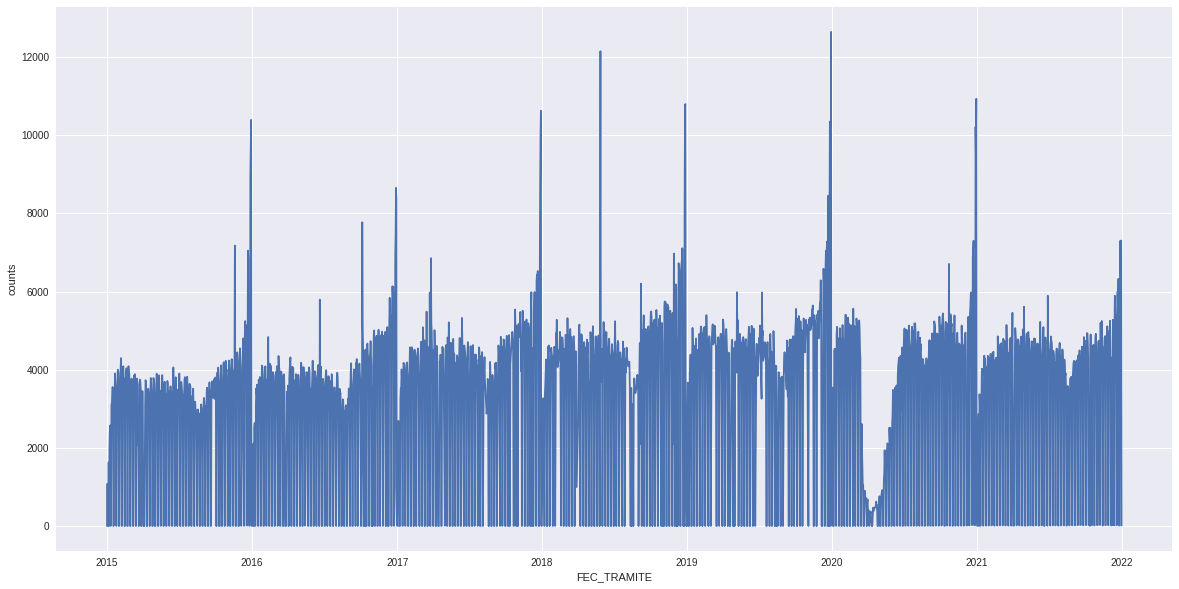

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

sns.lineplot(data=grouped, x='FEC_TRAMITE', y='counts')

La primera característica apreciable es que cada fin de año, el número de traspasos aumenta exponencialmente. Esto puede ser debido tanto a las fiestas, pagas extraordinarias o a la finalización de algún tipo de año fiscal, pero es algo frecuente todos los años.

En la época de verano, más concretamente en agosto, también se puede apreciar algo que se repite todos los años, una pequeña bajada en los traspasos de vehículos. No es una bajada importante, pero si es caracteristica del periodo.

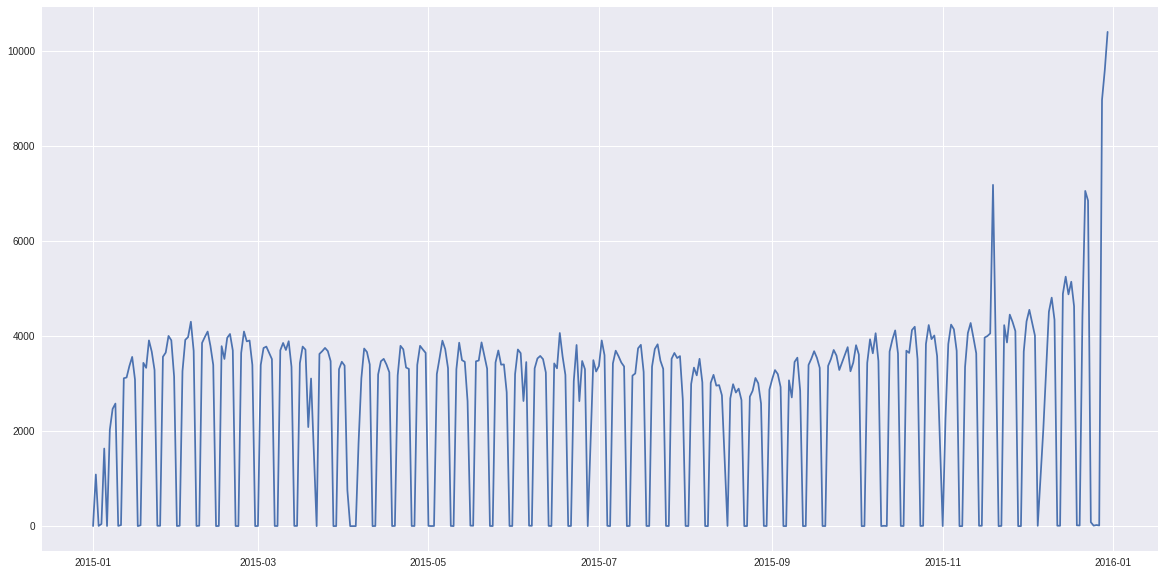

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2015-01-01') & (grouped['FEC_TRAMITE'] < '2015-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2015-01-01') & (grouped['FEC_TRAMITE'] < '2015-12-31')]['counts']
)

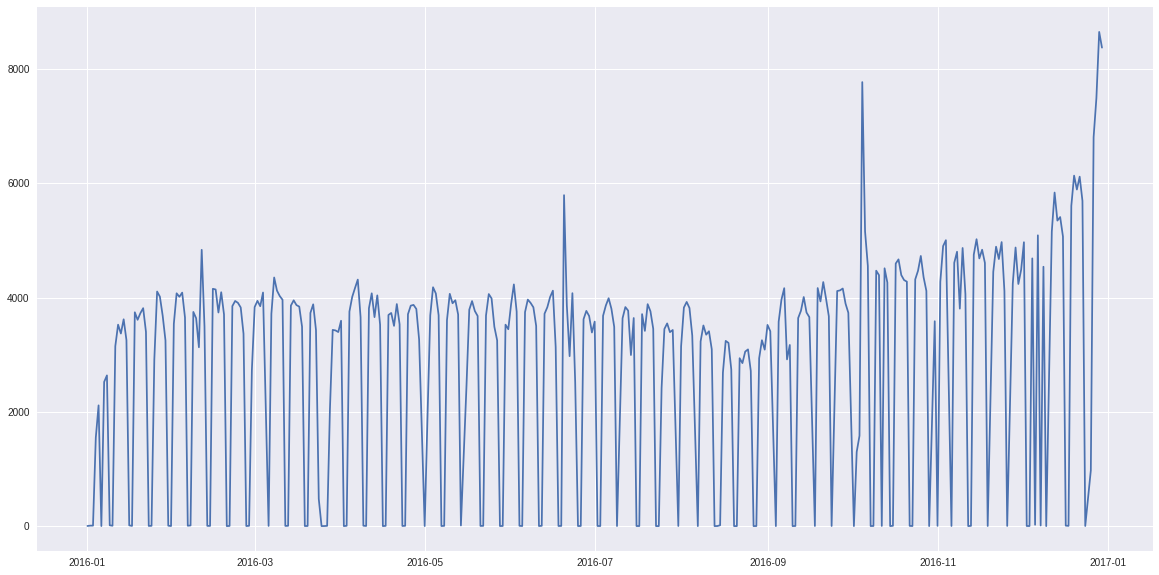

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2016-01-01') & (grouped['FEC_TRAMITE'] < '2016-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2016-01-01') & (grouped['FEC_TRAMITE'] < '2016-12-31')]['counts']
)

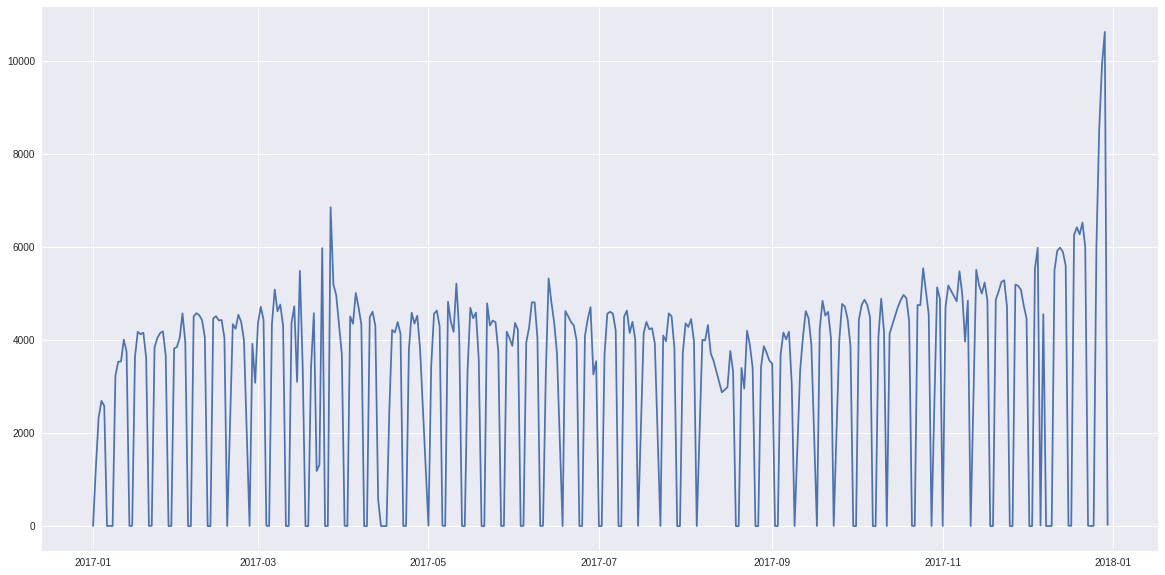

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2017-01-01') & (grouped['FEC_TRAMITE'] < '2017-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2017-01-01') & (grouped['FEC_TRAMITE'] < '2017-12-31')]['counts']
)

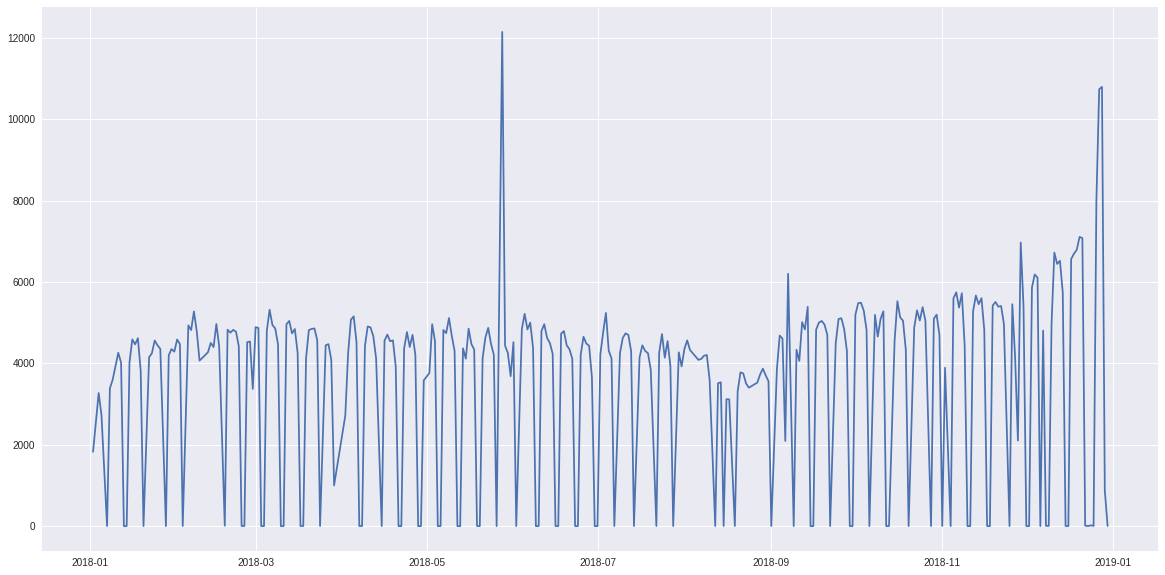

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2018-01-01') & (grouped['FEC_TRAMITE'] < '2018-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2018-01-01') & (grouped['FEC_TRAMITE'] < '2018-12-31')]['counts']
)

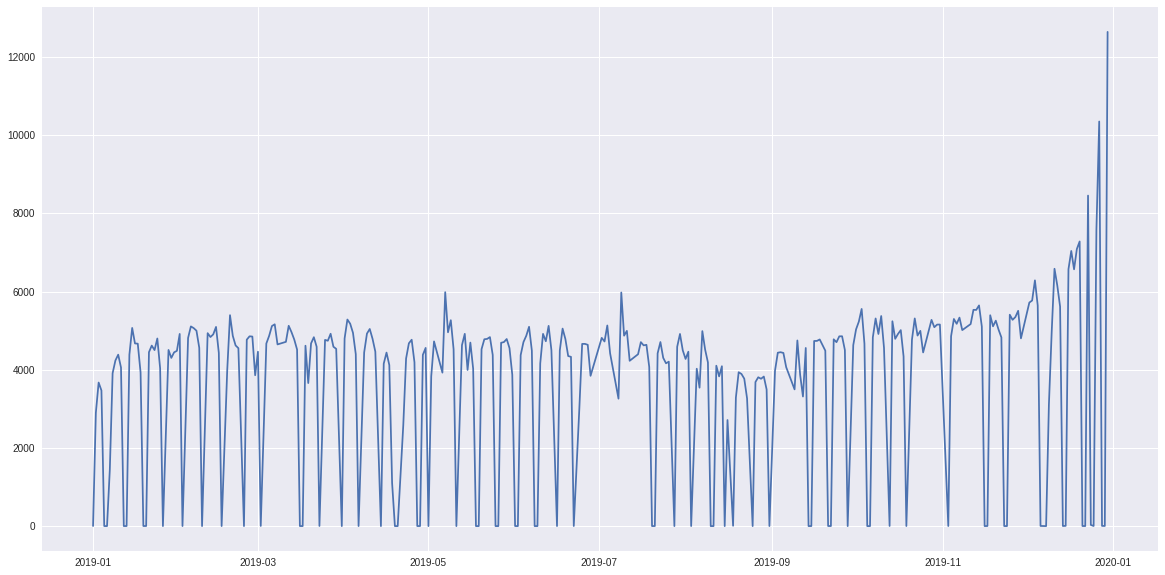

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2019-01-01') & (grouped['FEC_TRAMITE'] < '2019-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2019-01-01') & (grouped['FEC_TRAMITE'] < '2019-12-31')]['counts']
)

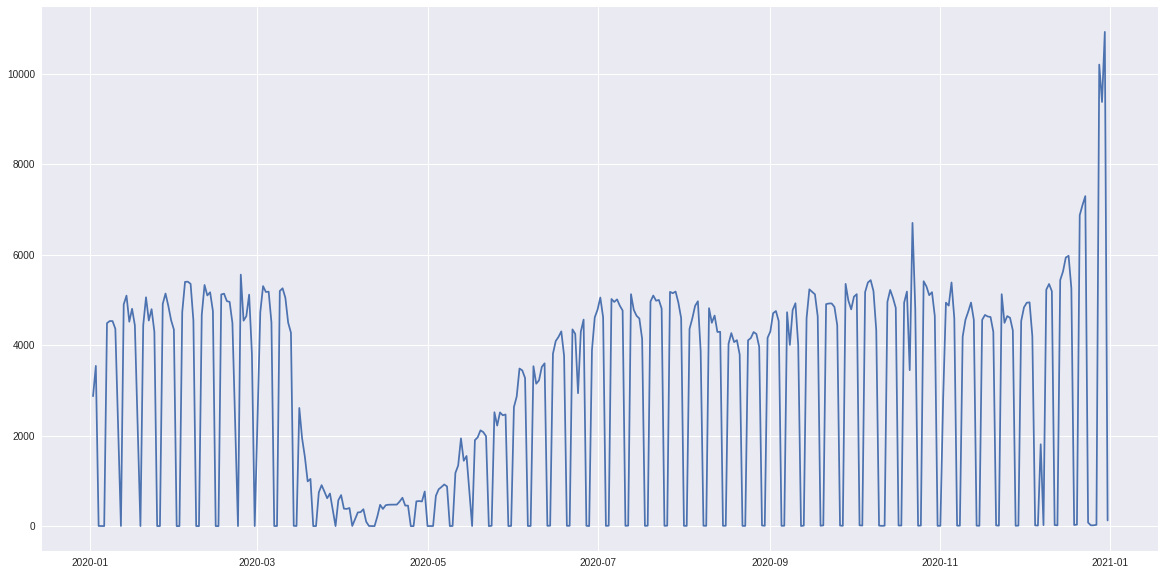

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2020-01-01') & (grouped['FEC_TRAMITE'] <= '2020-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2020-01-01') & (grouped['FEC_TRAMITE'] <= '2020-12-31')]['counts']
)

El año del comienzo de la pandemia es muy notable el periodo de la cuarentena, habiendo una bajada extraordinaria de

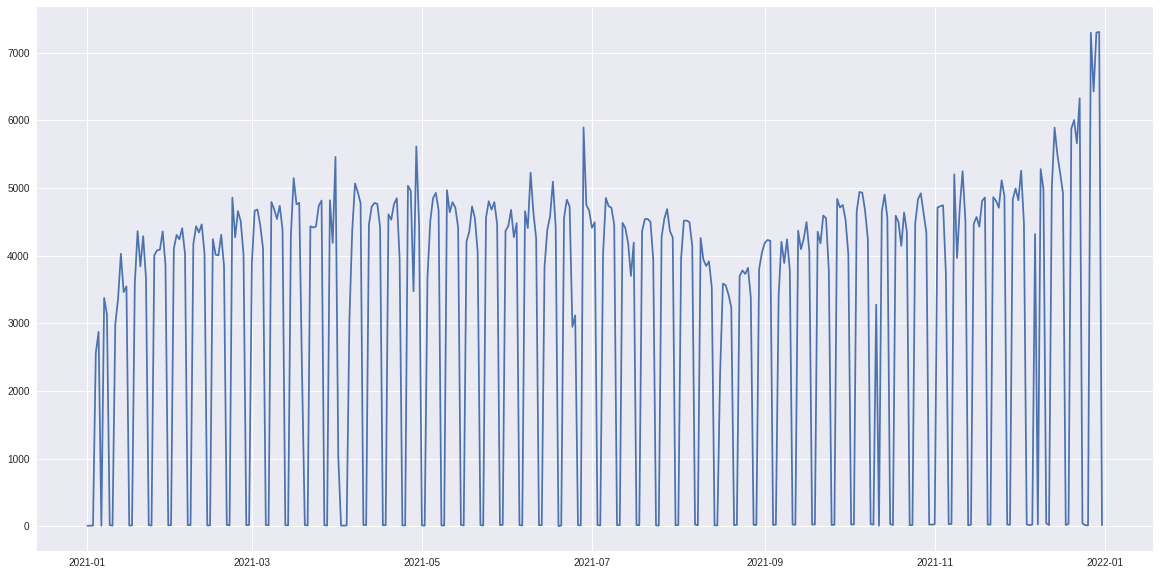

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2021-01-01') & (grouped['FEC_TRAMITE'] <= '2021-12-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2021-01-01') & (grouped['FEC_TRAMITE'] <= '2021-12-31')]['counts']
)

<AxesSubplot:xlabel='day_of_year', ylabel='counts'>

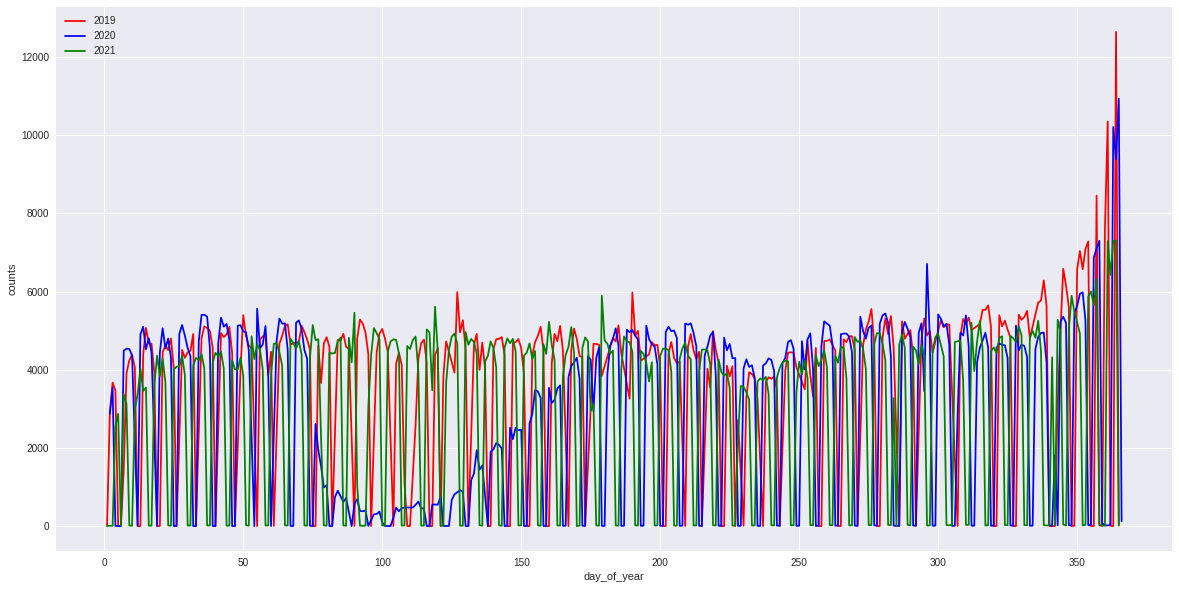

In [25]:
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

grouped['day_of_year'] = grouped['FEC_TRAMITE'].dt.dayofyear
grouped['year'] = grouped['FEC_TRAMITE'].dt.year

fig, ax = plt.subplots(figsize=(20,10))

#2019 -> red
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2019-01-01') & (grouped['FEC_TRAMITE'] <= '2019-12-31')], x='day_of_year', y='counts', color='red', label='2019')
#2020 -> blue
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2020-01-01') & (grouped['FEC_TRAMITE'] <= '2020-12-31')], x='day_of_year', y='counts', color='blue', label='2020')
#2020 -> green
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2021-01-01') & (grouped['FEC_TRAMITE'] <= '2021-12-31')], x='day_of_year', y='counts', color='green', label='2021')




Al comparar el año de la pandemia con el año anterior y posterior, es curioso que, salvo el confinamiento estricto, no se observa una bajada con despecto a los otros años a lo largo del resto del año 

La siguiente representación corresponde a una vista de las transacciones en la época del confinamiento restrictivo

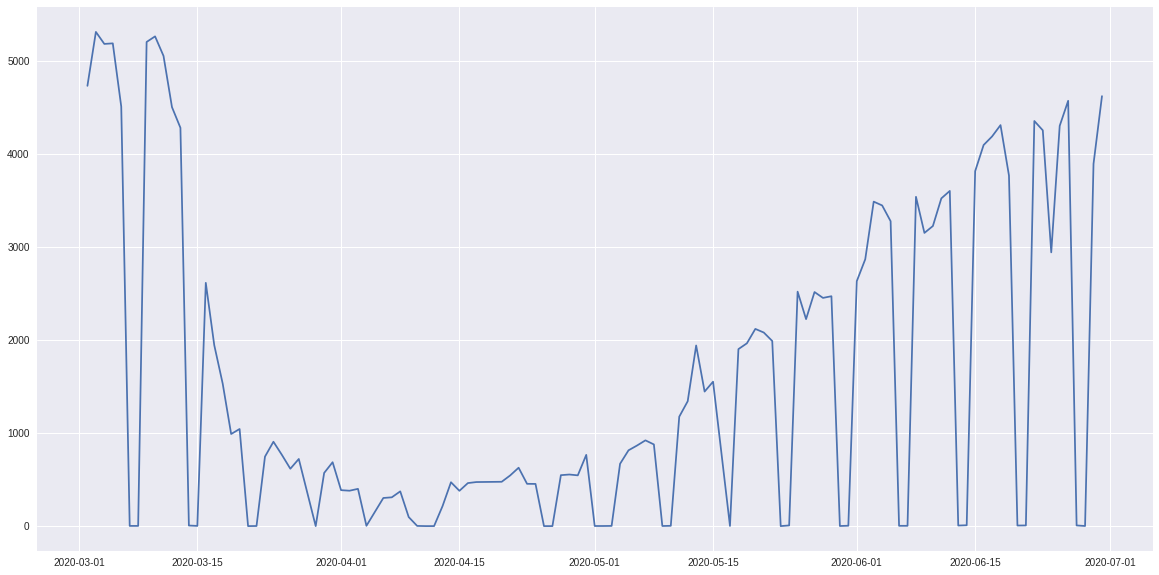

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')]['counts'],
)


Al comparar el periodo con respecto al del año siguiente, así como la media en el mismo, se ve un decremento de un 50% de  las transacciones

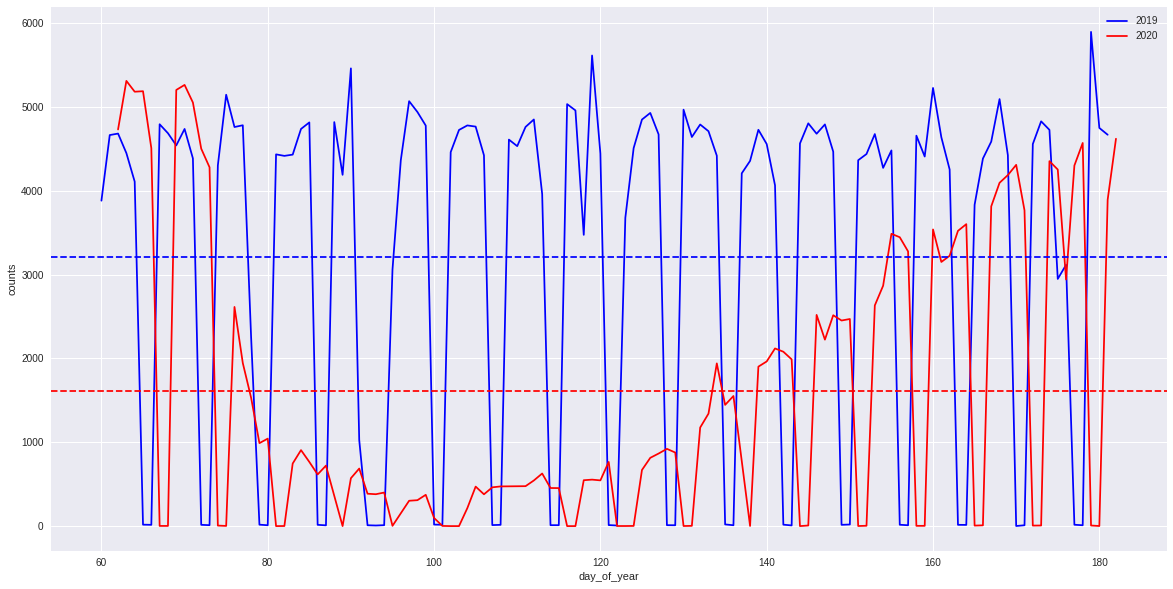

In [27]:

grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

grouped['day_of_year'] = grouped['FEC_TRAMITE'].dt.dayofyear
grouped['year'] = grouped['FEC_TRAMITE'].dt.year

fig, ax = plt.subplots(figsize=(20,10))

#2021 -> blue
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-06-30')], x='day_of_year', y='counts', color='blue', label='2019')
#2020 -> red
sns.lineplot(data=grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')], x='day_of_year', y='counts', color='red', label='2020')




plt.axhline(
    y = grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')]['counts'].describe()['mean'],
    color = 'r',
    linestyle = '--'
)

plt.axhline(
    y = grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-06-30')]['counts'].describe()['mean'],
    color = 'b',
    linestyle = '--'
)




In [28]:
mean_2021 = grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-06-30')]['counts'].describe()['mean']
mean_2020 = grouped[(grouped['FEC_TRAMITE'] >= '2020-03-01') & (grouped['FEC_TRAMITE'] <= '2020-06-30')]['counts'].describe()['mean']


percent = mean_2020 * 100 /  mean_2021
percent

50.38655986321484

Al fijarnos en la distribución de transacciones de un mes cualquiera vemos que hay una frecuencia reseñable. En los fines de semana las transacciones tienden a 0, a casi no haber ninguna.

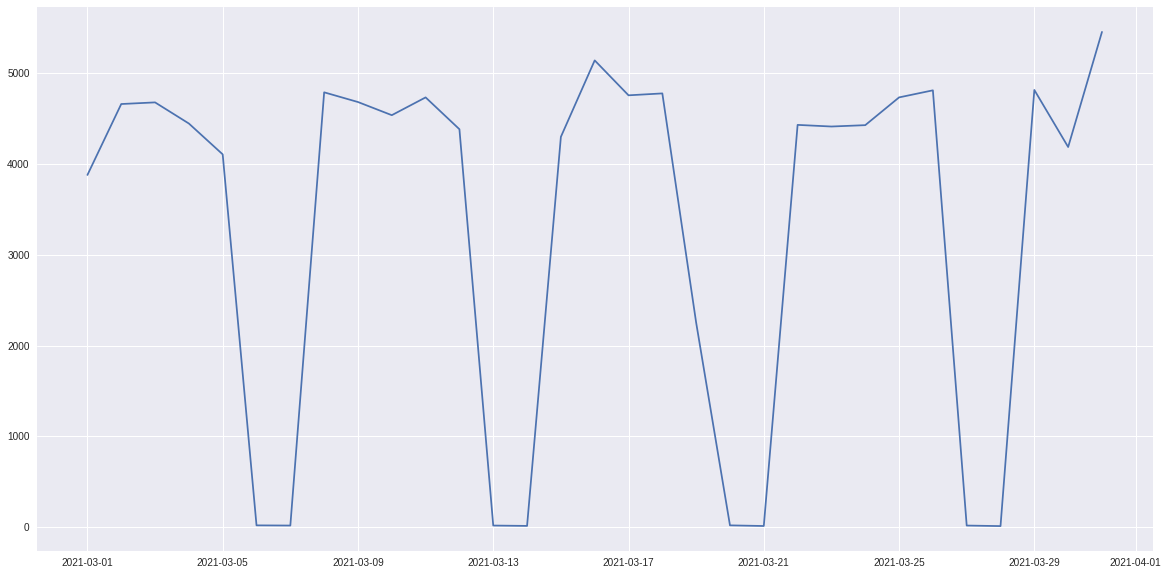

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-03-31')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2021-03-01') & (grouped['FEC_TRAMITE'] <= '2021-03-31')]['counts']
)

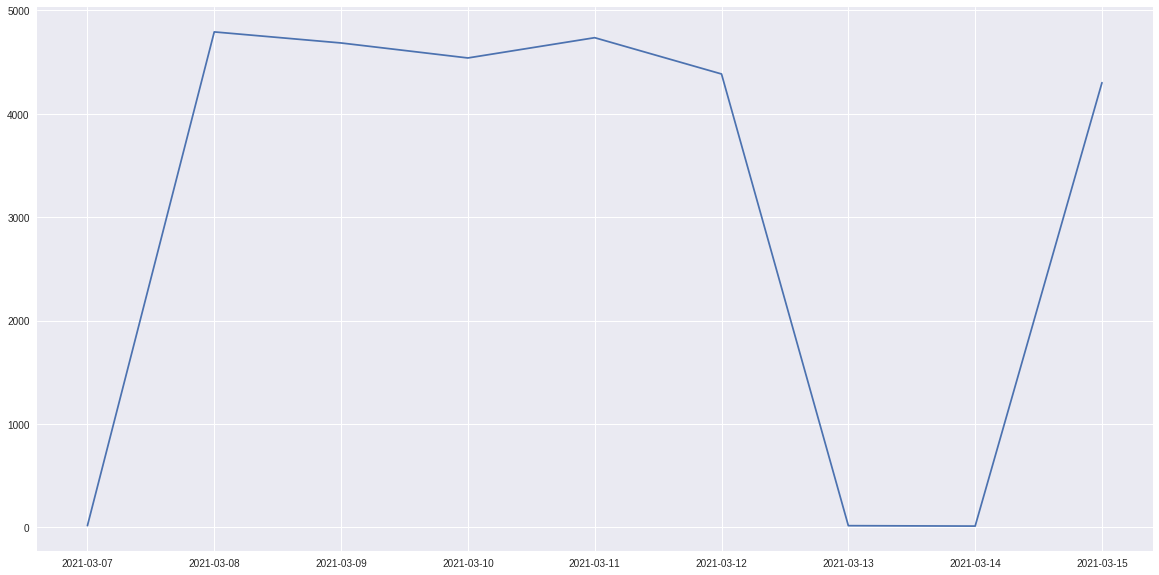

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['FEC_TRAMITE']).size().reset_index(name='counts')

plt.plot(
    grouped[(grouped['FEC_TRAMITE'] >= '2021-03-07') & (grouped['FEC_TRAMITE'] <= '2021-03-15')]['FEC_TRAMITE'],
    grouped[(grouped['FEC_TRAMITE'] >= '2021-03-07') & (grouped['FEC_TRAMITE'] <= '2021-03-15')]['counts']
)

Si contabilizamos las ventas de todo el periodo del dataset, es más claro que los fines de semana apenas quedan registradas transacciones.

In [31]:
df['day_of_week'] = df['FEC_TRAMITE'].dt.day_name()
df.groupby(['day_of_week']).size().reset_index(name='counts')

,day_of_week,counts
0,Friday,1401039
1,Monday,1458493
2,Saturday,2949
3,Sunday,1939
4,Thursday,1539692
5,Tuesday,1538938
6,Wednesday,1557857


Por lo que, para facilitar la obtención de la serie temporal, es importante identificar los días que son fin de semana

In [32]:
def is_weekend(day_week):
    if (day_week == 'Saturday' or day_week == 'Sunday'):
        return True
    else:
        return False

In [33]:
df['day_of_week'].apply(lambda x: is_weekend(x))

991462     False
854162     False
1577637    False
497824     False
1469491    False
           ...  
1220586    False
2715642    False
887793     False
1039360    False
1523560    False
Name: day_of_week, Length: 7500907, dtype: bool

In [34]:
df['is_weekend'] = df['day_of_week'].apply(lambda x: is_weekend(x))

### 2.2 Marcas

Otra forma de centrar las transaciones son las marcas de los turismos.

In [35]:
df.groupby(['MARCA_ITV']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,MARCA_ITV,counts
51,SEAT,702241
47,RENAULT,695955
60,VOLKSWAGEN,657032
45,PEUGEOT,653938
8,CITROEN,623827
44,OPEL,539406
18,FORD,526543
4,BMW,428143
2,AUDI,407864
39,MERCEDES-BENZ,405553


Podemos ver la evolución de las marcas de las que más traspasos se hacen y ver su evolución en el periodo

In [36]:
df.groupby(['MARCA_ITV','year_Q']).size().reset_index(name='counts')

,MARCA_ITV,year_Q,counts
0,ALFA ROMEO,2015,6120
1,ALFA ROMEO,2016,6144
2,ALFA ROMEO,2017,6476
3,ALFA ROMEO,2018,6638
4,ALFA ROMEO,2019,6613
...,...,...,...
417,VOLVO,2017,12638
418,VOLVO,2018,12988
419,VOLVO,2019,13322
420,VOLVO,2020,11105


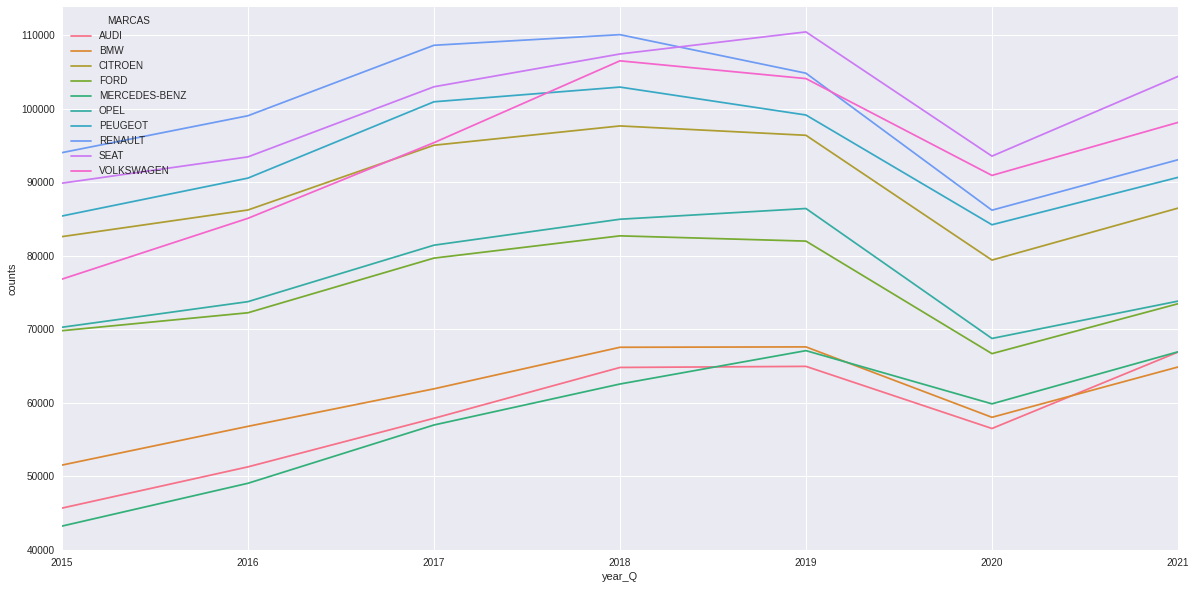

In [37]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['MARCA_ITV','year_Q']).size().reset_index(name='counts')

sns.lineplot(data=grouped[grouped['MARCA_ITV'].isin(
        df.groupby(['MARCA_ITV']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)['MARCA_ITV']
    ) ], x='year_Q', y='counts', hue='MARCA_ITV', legend='full')
ax.set_xlim([2015,2021])
ax.legend(title='MARCAS')

En el gráfico se puede apreciar la evolución de la evolución de las trasacciones por las marcas más "transaccionadas". Se puede ver como SEAT ha ido en aumento, superando al resto de marcas en 2019. También se comprueba la bajada de ventas en 2020 por el confinamiento.

### 2.3 Provincias

Se puede observar que Madrid se lleva la palma en lo que a transacciones de vehículos se refiere. Barcelona va por debajo por unos cuantos cientos de miles. Pero el salto importante se aprecia con respecto al tercer puesto, como se podrá ver mejor en la gráfica, la diferencia es de casi tres veces más.  

In [38]:
df.groupby(['ID_MUNICIPIO']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,ID_MUNICIPIO,counts
27,28,1123370
7,08,854043
45,46,372739
2,03,307919
40,41,299313
28,29,270179
29,30,251569
6,07,199348
44,45,194458
10,11,176894


In [39]:
df.groupby(['ID_MUNICIPIO','year_Q']).size().reset_index(name='counts').sort_values('counts', ascending=False)

,ID_MUNICIPIO,year_Q,counts
193,28,2019,178374
195,28,2021,177530
192,28,2018,175798
191,28,2017,160452
194,28,2020,154258
...,...,...,...
353,51,2018,1621
354,51,2019,1558
356,51,2021,1489
362,52,2020,1441


In [40]:
df['province'] = df['ID_MUNICIPIO'].apply(lambda x: return_province(x))

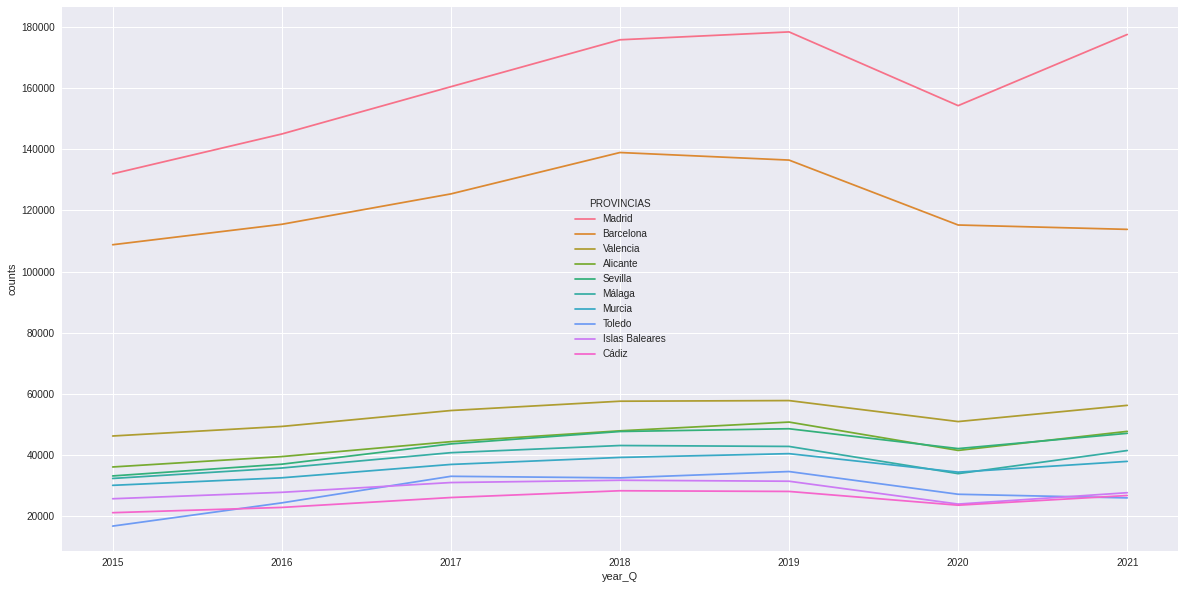

In [41]:
fig, ax = plt.subplots(figsize=(20,10))

grouped = df.groupby(['province','year_Q']).size().reset_index(name='counts').sort_values('counts', ascending=False)

sns.lineplot(data=grouped[grouped['province'].isin(
        df.groupby(['province']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)['province']
    ) ], x='year_Q', y='counts', hue='province', legend='full')
ax.legend(title='PROVINCIAS')

### 2.4 Persona Juridica-Física

Esta columna hace referencia a que si el dueño del vehículo es una persona física o juridica. Este valor es ideal para comprobar si el destino del vehículo es una persona o una empresa

In [42]:
df.groupby(['PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts').sort_values('counts', ascending=False)

,PERSONA_FISICA_JURIDICA,counts
0,D,6015388
1,X,1485519


<AxesSubplot:xlabel='PERSONA_FISICA_JURIDICA'>

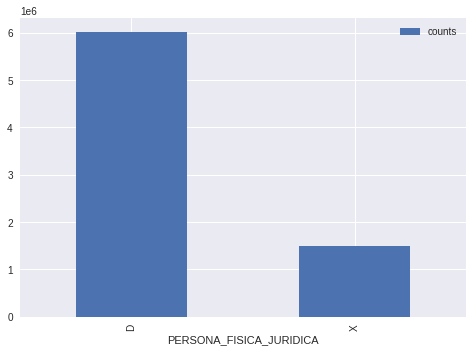

In [43]:
df.groupby(['PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts').sort_values('counts', ascending=False).plot.bar(x='PERSONA_FISICA_JURIDICA')

In [44]:
df.groupby(['year_Q', 'PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts')

,year_Q,PERSONA_FISICA_JURIDICA,counts
0,2015,D,803711
1,2015,X,109802
2,2016,D,804690
3,2016,X,182761
4,2017,D,869068
5,2017,X,233508
6,2018,D,918555
7,2018,X,259654
8,2019,D,931050
9,2019,X,260894


In [45]:
df.groupby(['year_Q','ID_MUNICIPIO','PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts')

,year_Q,ID_MUNICIPIO,PERSONA_FISICA_JURIDICA,counts
0,2015,01,D,5662
1,2015,01,X,1198
2,2015,02,D,6267
3,2015,02,X,628
4,2015,03,D,32514
...,...,...,...,...
723,2021,50,X,3618
724,2021,51,D,1464
725,2021,51,X,25
726,2021,52,D,1627


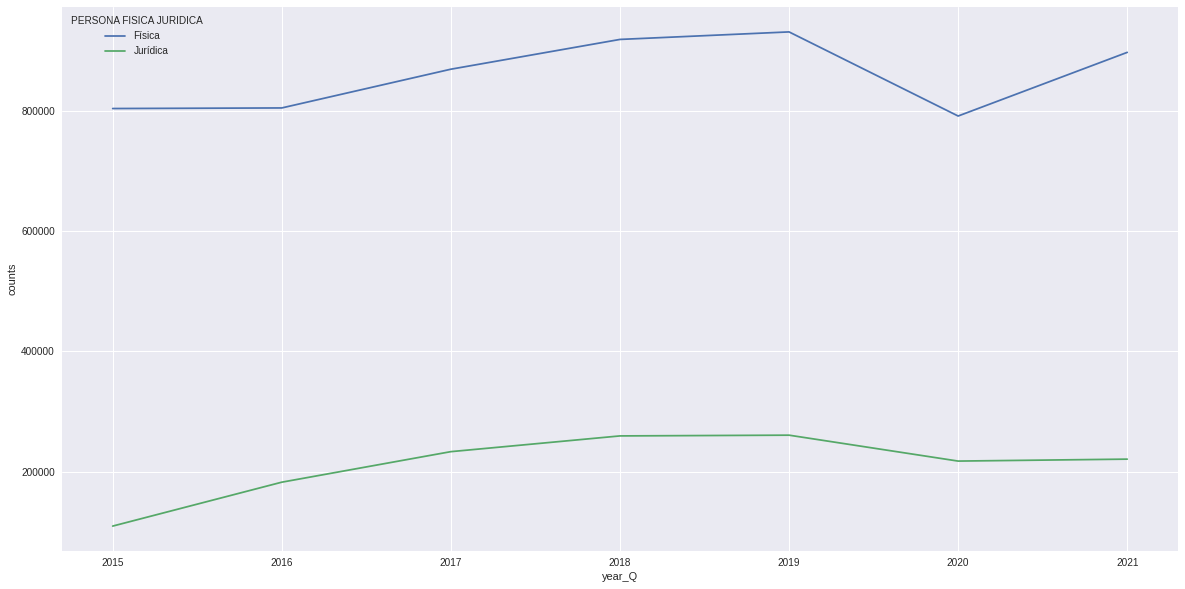

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['year_Q', 'PERSONA_FISICA_JURIDICA']).size().reset_index(name='counts')

grouped['LITERAL_FISICA_JURIDICA'] = grouped['PERSONA_FISICA_JURIDICA'].apply(lambda x: 'Jurídica' if x == 'X' else 'Física')

sns.lineplot(data=grouped, x='year_Q', y='counts', hue='LITERAL_FISICA_JURIDICA', legend='full')

ax.legend(title='PERSONA FISICA JURIDICA')

Podemos ver una tendencia de unas marcas frente a otras dependiendo del tipo de persona

In [47]:
grouped = df.groupby(['PERSONA_FISICA_JURIDICA','MARCA_ITV']).size().reset_index(name='counts')
grouped[grouped['PERSONA_FISICA_JURIDICA'] == 'D'].sort_values('counts', ascending=False).head(10)

,PERSONA_FISICA_JURIDICA,MARCA_ITV,counts
47,D,RENAULT,588060
51,D,SEAT,582121
60,D,VOLKSWAGEN,534656
45,D,PEUGEOT,531872
8,D,CITROEN,513903
44,D,OPEL,451183
18,D,FORD,439784
4,D,BMW,332633
2,D,AUDI,319514
39,D,MERCEDES-BENZ,305433


In [48]:
grouped = df.groupby(['PERSONA_FISICA_JURIDICA','MARCA_ITV']).size().reset_index(name='counts')
grouped[grouped['PERSONA_FISICA_JURIDICA'] == 'X'].sort_values('counts', ascending=False).head(10)

,PERSONA_FISICA_JURIDICA,MARCA_ITV,counts
122,X,VOLKSWAGEN,122376
107,X,PEUGEOT,122066
113,X,SEAT,120120
70,X,CITROEN,109924
109,X,RENAULT,107895
101,X,MERCEDES-BENZ,100120
66,X,BMW,95510
64,X,AUDI,88350
106,X,OPEL,88223
80,X,FORD,86759


### 2.5 Número de Plazas

Este campo es desconcertante. El dataset está filtrado por vehículos de tipo turismo en el notebook previo a este, por lo que la variación de asientos es sorprendete. Aquí puede deberse a un factor humano en los casos más extremos, y ha turismos de carácteristicas especiales en otros. Es claro que la mayoría de turismos dispone de 5 plazas

In [49]:
df.groupby(['NUM_PLAZAS']).size().reset_index(name='counts')

,NUM_PLAZAS,counts
0,0,260
1,1,297
2,2,69351
3,3,2066
4,4,487763
5,5,6519901
6,6,12113
7,7,371811
8,8,23141
9,9,14201


<AxesSubplot:>

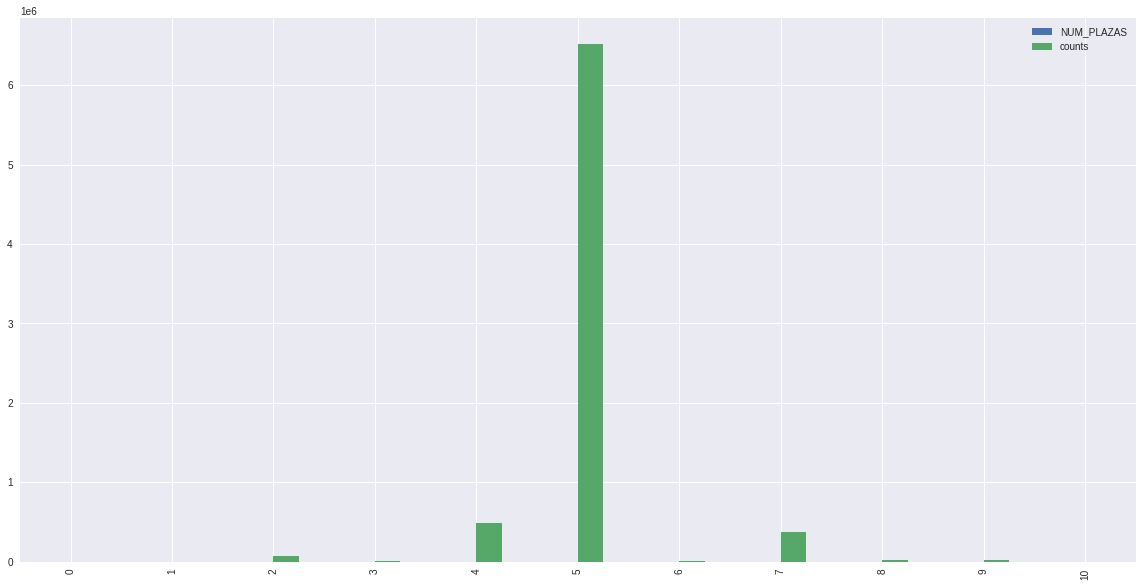

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
df.groupby(['NUM_PLAZAS']).size().reset_index(name='counts').plot.bar(ax=ax)

### 2.6 Cilindrada

Se define cilindrada como "Es la suma del volumen útil de todos los cilindros. Suele medirse en centímetros cúbicos (cm3), aunque también es usual su equivalencia en litros (2500 cm3 = 2,5 litros)". La mayoría de los vehículos gira en torno a los 1500-2000 cm3

In [51]:
df.groupby(['CILINDRADA_ITV']).size().reset_index(name='counts')

,CILINDRADA_ITV,counts
0,0,13534
1,1,129
2,4,6
3,8,1
4,16,1
...,...,...
3005,9998,1
3006,9999,5
3007,10000,2
3008,19980,1


In [52]:
bins = [0, 10, 100, 500, 1000, 5000, 10000, 25000]

df['CILINDRADA_ITV'].value_counts(bins=bins, sort=False).reset_index()

,index,CILINDRADA_ITV
0,"(-0.001, 10.0]",13670
1,"(10.0, 100.0]",2
2,"(100.0, 500.0]",552
3,"(500.0, 1000.0]",384631
4,"(1000.0, 5000.0]",7093577
5,"(5000.0, 10000.0]",8472
6,"(10000.0, 25000.0]",3


<AxesSubplot:xlabel='index'>

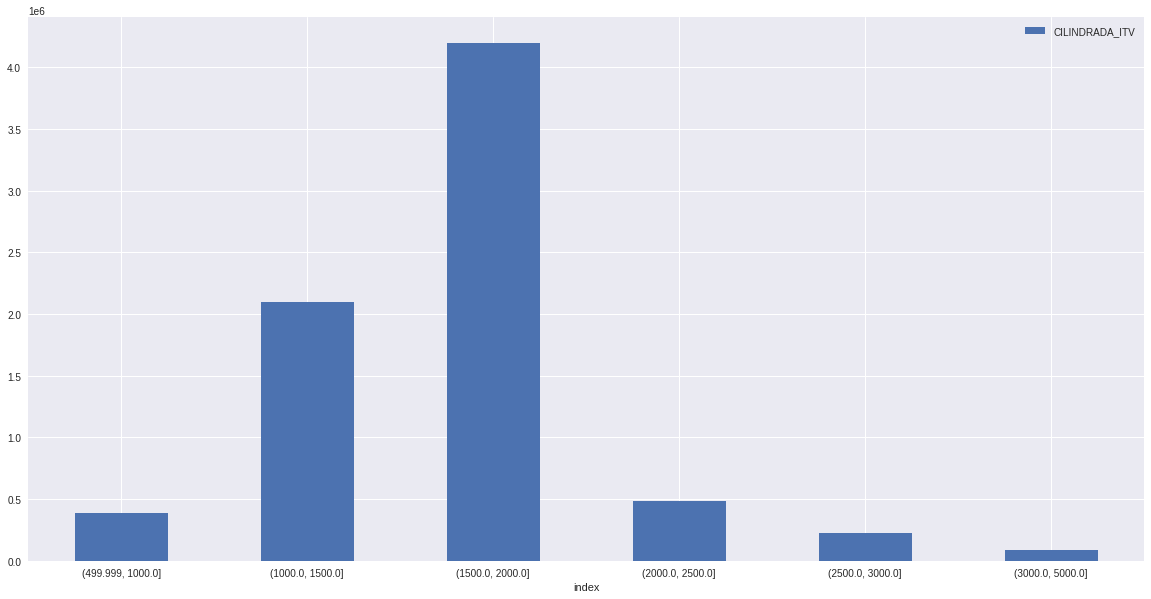

In [53]:
fig, ax = plt.subplots(figsize=(20,10))

bins = [500, 1000, 1500, 2000, 2500, 3000, 5000]

df['CILINDRADA_ITV'].value_counts(bins=bins, sort=False).reset_index().plot.bar(x='index', y='CILINDRADA_ITV', rot=0, ax=ax)


### 2.7 Potencia

A diferencia de la cilindrada, la potencia de un turismo está más repartida

In [54]:
df.groupby(['POTENCIA_ITV']).size().reset_index(name='counts')

,POTENCIA_ITV,counts
0,0.00,6
1,0.01,19
2,0.02,4
3,0.03,7
4,0.04,15
...,...,...
2820,131.70,1
2821,152.20,1
2822,190.95,1
2823,198.40,1


In [55]:
bins = [0, 10, 15, 25, 30, 35, 40, 45, 50]

df['POTENCIA_ITV'].value_counts(bins=bins, sort=False).reset_index()

,index,POTENCIA_ITV
0,"(-0.001, 10.0]",1246183
1,"(10.0, 15.0]",5771165
2,"(15.0, 25.0]",444096
3,"(25.0, 30.0]",22507
4,"(30.0, 35.0]",13750
5,"(35.0, 40.0]",2595
6,"(40.0, 45.0]",264
7,"(45.0, 50.0]",76


<AxesSubplot:xlabel='index'>

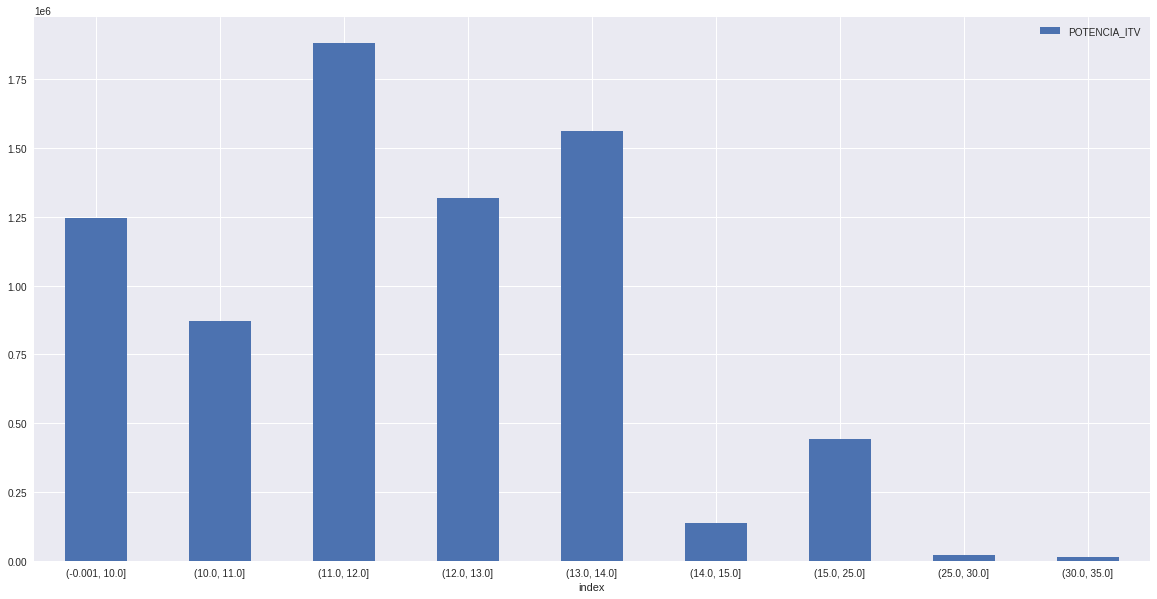

In [56]:
fig, ax = plt.subplots(figsize=(20,10))

bins = [0, 10, 11, 12, 13, 14, 15, 25, 30, 35]

df['POTENCIA_ITV'].value_counts(bins=bins, sort=False).reset_index().plot.bar(x='index', y='POTENCIA_ITV', rot=0, ax=ax)


### 2.8 Emisiones CO2

Como el nombre indica, hace referencia a las emisiones de CO2 que expulsa el coche

In [57]:
df.groupby(['CO2_ITV']).size().reset_index(name='counts')

,CO2_ITV,counts
0,1.0,411
1,2.0,4
2,3.0,5
3,4.0,16
4,5.0,30
...,...,...
458,980.0,1
459,989.0,1
460,990.0,24
461,998.0,1


<AxesSubplot:xlabel='index'>

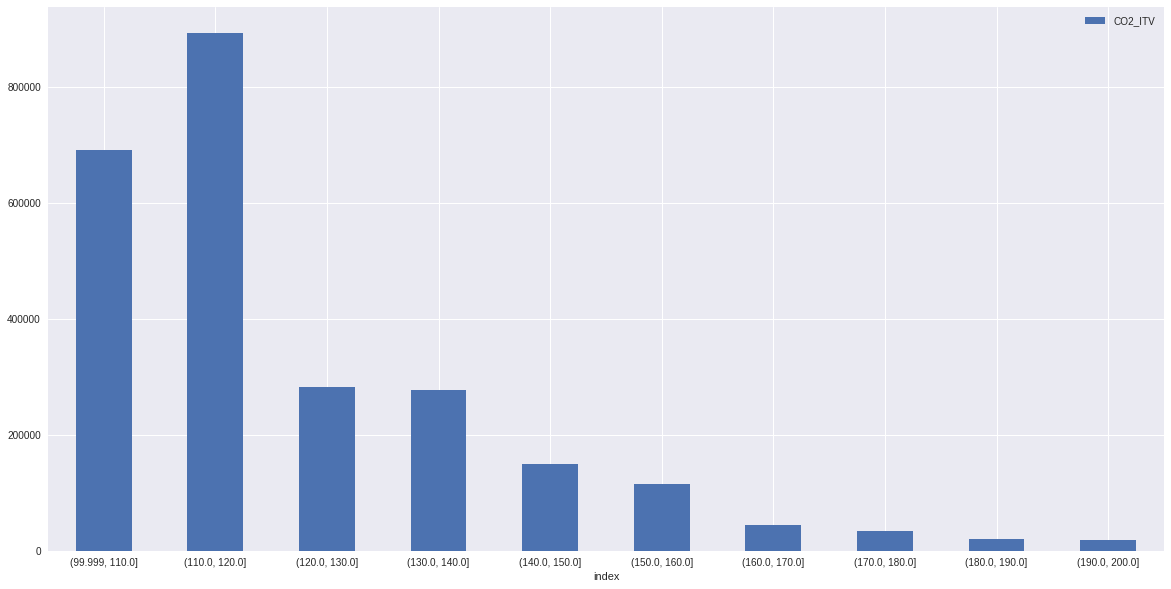

In [58]:
fig, ax = plt.subplots(figsize=(20,10))

bins = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

df['CO2_ITV'].value_counts(bins=bins, sort=False).reset_index().plot.bar(x='index', y='CO2_ITV', rot=0, ax=ax)


Podemos diferenciar las marcas más contaminantes para hacer una comparativa. Es apreciable que los más contaminantes son marcas americanas o de lujo

In [59]:
df.groupby(['MARCA_ITV'])['CO2_ITV'].agg('mean').reset_index().sort_values('CO2_ITV', ascending=False).head(10)

,MARCA_ITV,CO2_ITV
30,LAMBORGHINI,339.493056
19,GMC,338.000000
3,BENTLEY,323.593548
16,FERRARI,307.571189
1,ASTON MARTIN,305.746753
38,MCLAREN,259.481013
5,CADILLAC,239.611940
36,MASERATI,228.276305
7,CHRYSLER,216.371872
25,IVECO,212.500000


<AxesSubplot:xlabel='MARCA_ITV'>

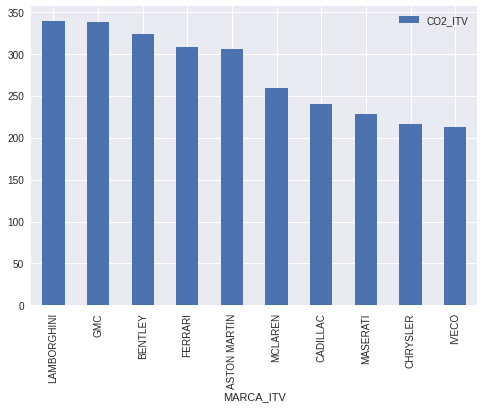

In [60]:
 df.groupby(['MARCA_ITV'])['CO2_ITV'].agg('mean').reset_index().sort_values('CO2_ITV', ascending=False).head(10).plot.bar(x='MARCA_ITV')

### 2.9 Renting

Vehículo de renting o de compra tradicional. No es un campo relevante ya que en este país el renting es minoritario

In [61]:
df.groupby(['RENTING']).size().reset_index(name='counts')

,RENTING,counts
0,N,7434915
1,S,15669


<AxesSubplot:xlabel='RENTING'>

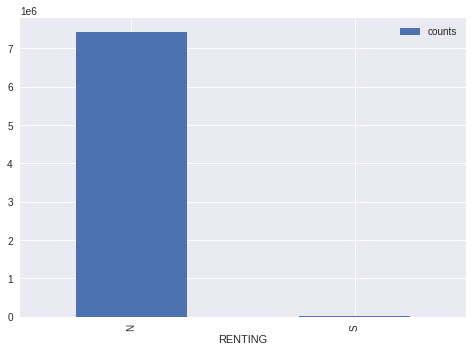

In [62]:
df.groupby(['RENTING']).size().reset_index(name='counts').sort_values('counts', ascending=False).plot.bar(x='RENTING')

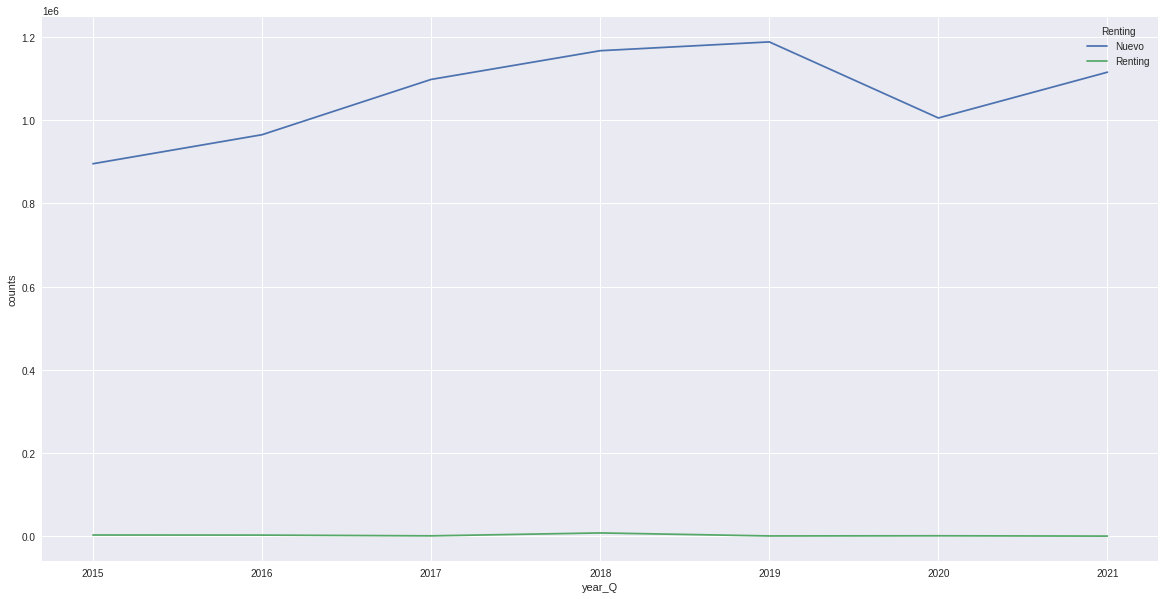

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['year_Q', 'RENTING']).size().reset_index(name='counts')

grouped['LITERAL_RENTING'] = grouped['RENTING'].apply(lambda x: 'Nuevo' if x == 'N' else 'Renting')

sns.lineplot(data=grouped, x='year_Q', y='counts', hue='LITERAL_RENTING', legend='full')

ax.legend(title='Renting')

### 2.10 Homologación Europea

La inmensa mayoría de los vehículos de este dataset tiene categoría M1

In [64]:
df.groupby(['CATEGORÍA_HOMOLOGACIÓN_EUROPEA_ITV']).size().reset_index(name='counts')

,CATEGORÍA_HOMOLOGACIÓN_EUROPEA_ITV,counts
0,*74,3
1,1000,1
2,ATV,3
3,L1E,2
4,L3E,13
5,L4E,13
6,L6E,1
7,M1,6666101
8,M1G,1769
9,M2,2


### 2.11 Nivel de emisiones

In [65]:
df.groupby(['NIVEL_EMISIONES_EURO_ITV']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,NIVEL_EMISIONES_EURO_ITV,counts
437,EURO 3,1790060
452,EURO 4,1511204
432,EURO 2,801115
662,EURO 6W,749369
479,EURO 5,637750
597,EURO 6 W,211065
578,EURO 6,204897
423,EURO 1,201771
563,EURO 5J,193148
626,EURO 6AG,171077


<AxesSubplot:xlabel='NIVEL_EMISIONES_EURO_ITV'>

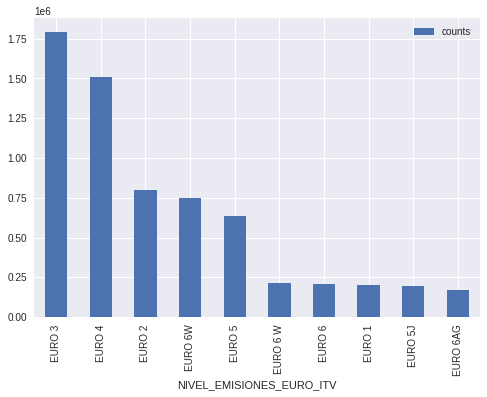

In [66]:
df.groupby(['NIVEL_EMISIONES_EURO_ITV']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10).plot.bar(x='NIVEL_EMISIONES_EURO_ITV')

### 2.12 Vehículo Eléctrico y autonomía

- PHEV Eléctrico Enchufable
- REEV Eléctrico de Autonomía Extendida
- HEV Eléctrico Híbrido
- BEV Eléctrico de Batería

In [67]:
df.groupby(['CATEGORÍA_VEHÍCULO_ELÉCTRICO']).size().reset_index(name='counts')

,CATEGORÍA_VEHÍCULO_ELÉCTRICO,counts
0,BEV,12727
1,FCEV,1
2,HEV,89080
3,HVE,2
4,PHEV,9423
5,REEV,726


<AxesSubplot:xlabel='CATEGORÍA_VEHÍCULO_ELÉCTRICO'>

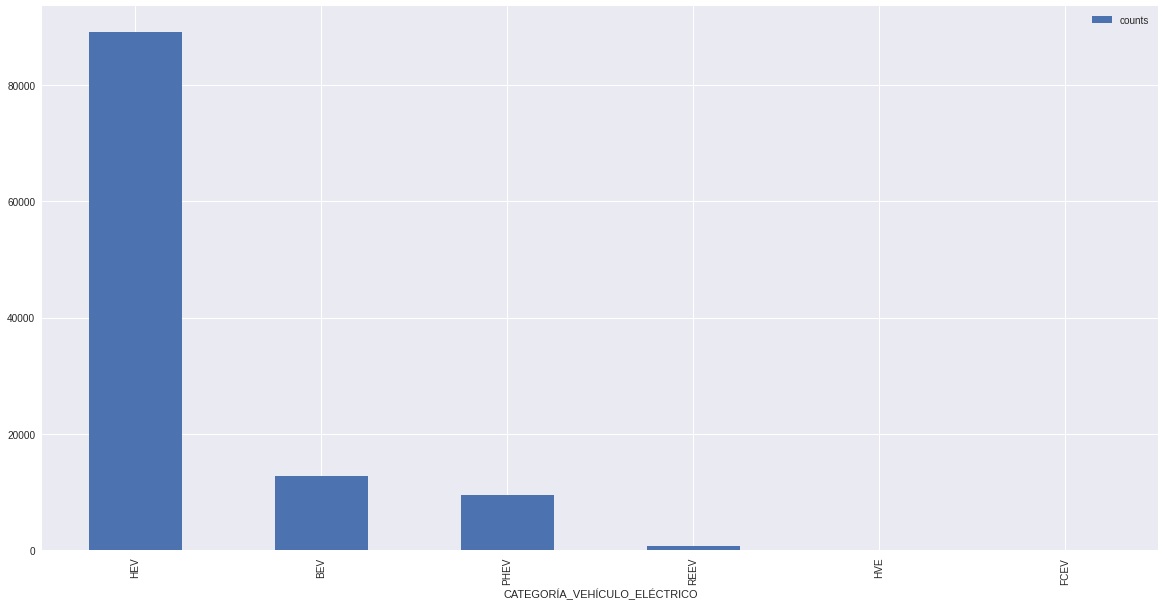

In [68]:
fig, ax = plt.subplots(figsize=(20,10))


df.groupby(['CATEGORÍA_VEHÍCULO_ELÉCTRICO']).size().reset_index(name='counts').sort_values('counts', ascending=False).plot.bar(x='CATEGORÍA_VEHÍCULO_ELÉCTRICO', ax=ax)

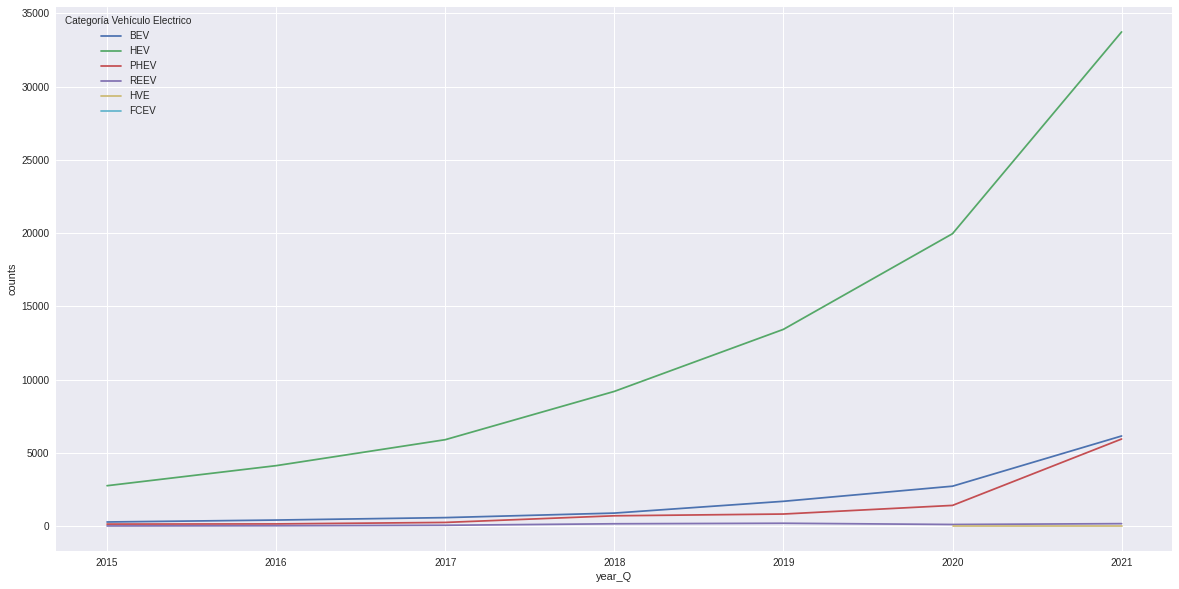

In [69]:
fig, ax = plt.subplots(figsize=(20,10))
grouped = df.groupby(['year_Q', 'CATEGORÍA_VEHÍCULO_ELÉCTRICO']).size().reset_index(name='counts')

sns.lineplot(data=grouped, x='year_Q', y='counts', hue='CATEGORÍA_VEHÍCULO_ELÉCTRICO', legend='full')

ax.legend(title='Categoría Vehículo Electrico')

# PHEV Eléctrico Enchufable
# REEV Eléctrico de Autonomía Extendida
# HEV Eléctrico Híbrido
# BEV Eléctrico de Batería

In [70]:
df.groupby(['AUTONOMÍA_VEHÍCULO_ELÉCTRICO']).size().reset_index(name='counts')

,AUTONOMÍA_VEHÍCULO_ELÉCTRICO,counts
0,0.0,2268952
1,100.0,108
2,200.0,6
3,300.0,1
4,400.0,2
...,...,...
354,62400.0,7
355,63200.0,29
356,64000.0,2
357,65200.0,1


In [71]:
bins = [1000, 5000, 10000, 15000, 20000]

df['AUTONOMÍA_VEHÍCULO_ELÉCTRICO'].value_counts(bins=bins, sort=False).reset_index()

,index,AUTONOMÍA_VEHÍCULO_ELÉCTRICO
0,"(999.999, 5000.0]",3156
1,"(5000.0, 10000.0]",6278
2,"(10000.0, 15000.0]",1697
3,"(15000.0, 20000.0]",4076


<AxesSubplot:xlabel='index'>

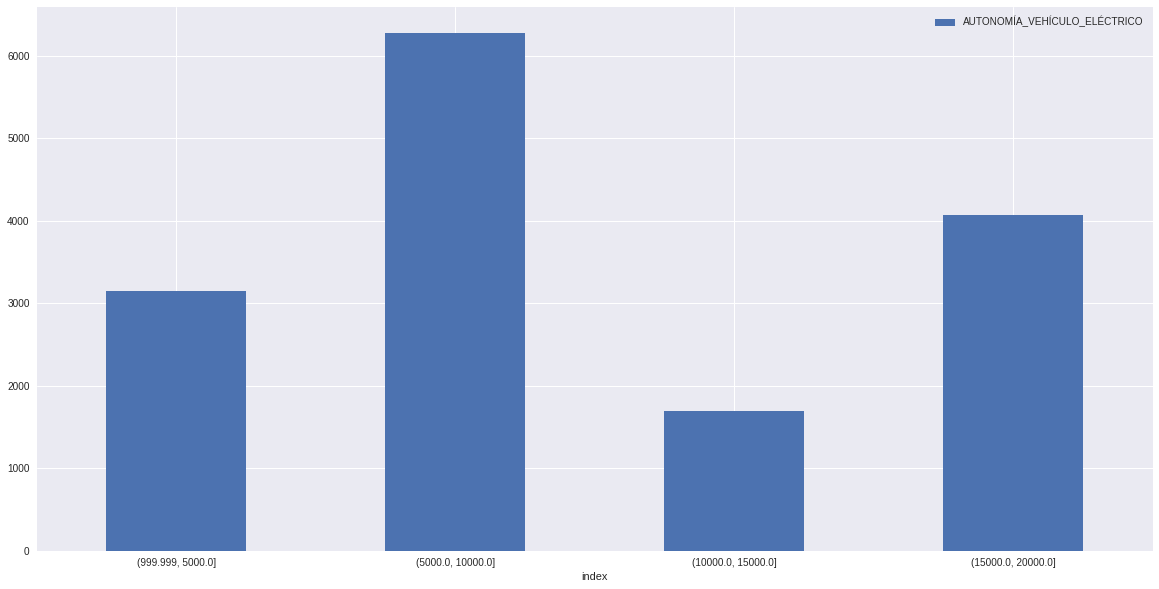

In [72]:
fig, ax = plt.subplots(figsize=(20,10))

bins = [1000, 5000, 10000, 15000, 20000]

df['AUTONOMÍA_VEHÍCULO_ELÉCTRICO'].value_counts(bins=bins, sort=False).reset_index().plot.bar(x='index', y='AUTONOMÍA_VEHÍCULO_ELÉCTRICO', rot=0, ax=ax)